In [15]:
import os

import mxnet as mx
import mxnet.ndarray as nd
from mxnet.gluon.block import HybridBlock
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import model_store
from mxnet import autograd

from viz.layers import Activation
from utils import convert_to_grayscale

import numpy as np
import utils
import cv2

from matplotlib import pyplot as plt

class Conv2D(mx.gluon.HybridBlock):

    conv_output = None
    capture_layer_name = None

    def __init__(self, channels, kernel_size, strides=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, layout='NCHW',
                 activation=None, use_bias=True, weight_initializer=None,
                 bias_initializer='zeros', in_channels=0, **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.conv = nn.Conv2D(channels, kernel_size, strides=strides, padding=padding,
                             dilation=dilation, groups=groups, layout=layout,
                             activation=activation, use_bias=use_bias, weight_initializer=weight_initializer,
                             bias_initializer=bias_initializer, in_channels=in_channels)

    def hybrid_forward(self, F, x):
        out = self.conv(x)
        name = self._prefix[:-1]
        if name == Conv2D.capture_layer_name:
            out.attach_grad()
            Conv2D.conv_output = out
        return out

In [16]:
def _get_grad(net, image, class_id=None, conv_layer_name=None, image_grad=False):

    if image_grad:
        image.attach_grad()
        Conv2D.capture_layer_name = None
    else:
        # Tell convviz.Conv2D which layer's output and gradient needs to be recorded
        Conv2D.capture_layer_name = conv_layer_name
    
    # Run the network
    with autograd.record(train_mode=False):
        out = net(image)
    
    # If user didn't provide a class id, we'll use the class that the network predicted
    if class_id == None:
        model_output = out.asnumpy()
        target_class = np.argmax(model_output)

    # Create a one-hot target with class_id and backprop with the created target
    one_hot_target = mx.nd.one_hot(mx.nd.array([target_class]), 1000)
    out.backward(one_hot_target, train_mode=False)

    if image_grad:
        return image.grad[0].asnumpy()
    else:
        # Return the recorded convolution output and gradient
        conv_out = Conv2D.conv_output
        return conv_out[0].asnumpy(), conv_out.grad[0].asnumpy()


def get_conv_out_grad(net, image, class_id=None, conv_layer_name=None):
    return _get_grad(net, image, class_id, conv_layer_name, image_grad=False)

def get_image_grad(net, image, class_id=None):
    return _get_grad(net, image, class_id, image_grad=True)

def get_image(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    gradient = np.uint8(gradient * 255).transpose(1, 2, 0)
    gradient = gradient[..., ::-1]
    return gradient

In [3]:
class AlexNet(HybridBlock):
    def __init__(self, classes=1000, **kwargs):
        super(AlexNet, self).__init__(**kwargs)
        with self.name_scope():
            self.features = nn.HybridSequential(prefix='')
            with self.features.name_scope():
                self.features.add(Conv2D(64, kernel_size=11, strides=4, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(nn.MaxPool2D(pool_size=3, strides=2))
                
                self.features.add(Conv2D(192, kernel_size=5, padding=2))
                self.features.add(Activation('relu'))
                self.features.add(nn.MaxPool2D(pool_size=3, strides=2))
                
                self.features.add(Conv2D(384, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                
                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                
                self.features.add(Conv2D(256, kernel_size=3, padding=1))
                self.features.add(Activation('relu'))
                self.features.add(nn.MaxPool2D(pool_size=3, strides=2))
                
                self.features.add(nn.Flatten())

                self.features.add(nn.Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(nn.Dropout(0.5))

                self.features.add(nn.Dense(4096))
                self.features.add(Activation('relu'))
                self.features.add(nn.Dropout(0.5))

            self.output = nn.Dense(classes)

    def hybrid_forward(self, F, x):
        x = self.features(x)
        x = self.output(x)
        return x

# Constructor
def alexnet(pretrained=False, ctx=mx.cpu(),
            root=os.path.join('~', '.mxnet', 'models'), **kwargs):
    r"""AlexNet model from the `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Parameters
    ----------
    pretrained : bool, default False
        Whether to load the pretrained weights for model.
    ctx : Context, default CPU
        The context in which to load the pretrained weights.
    root : str, default '~/.mxnet/models'
        Location for keeping the model parameters.
    """
    net = AlexNet(**kwargs)
    if pretrained:
        net.load_params(model_store.get_model_file('alexnet', root=root), ctx=ctx)
    return net

def preprocess(data):
    data = mx.image.imresize(data, 256, 256)
    data, _ = mx.image.center_crop(data, (224, 224))
    data = data.astype(np.float32)
    data = data/255
    data = mx.image.color_normalize(data,
                                    mean=mx.nd.array([0.485, 0.456, 0.406]),
                                    std=mx.nd.array([0.229, 0.224, 0.225]))
    data = mx.nd.transpose(data, (2,0,1))
    return data

In [4]:
alexnet = alexnet(pretrained=True)

In [57]:
imgpath = "img/dog2.jpg"
with open(imgpath, 'rb') as fp:
    str_image = fp.read()

image = mx.img.imdecode(str_image)
image = preprocess(image)
image = image.expand_dims(axis=0)

In [58]:
imggrad = get_image_grad(alexnet, image)

In [59]:
conv_out, conv_out_grad = get_conv_out_grad(alexnet, image, conv_layer_name='alexnet0_conv2d0')

## Guided backprop

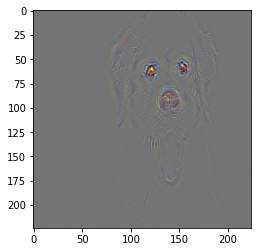

In [60]:
img = get_image(imggrad)
plt.imshow(img)

In [61]:
def save_class_activation_on_image(org_img, activation_map, file_name):

    # Grayscale activation map
    path_to_file = file_name+'_Cam_Grayscale.jpg'
    cv2.imwrite(path_to_file, activation_map)
    # Heatmap of activation map
    activation_heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_HSV)
    path_to_file = file_name+'_Cam_Heatmap.jpg'
    cv2.imwrite(path_to_file, activation_heatmap)
    # Heatmap on picture
    org_img = cv2.resize(org_img, (224, 224))

    img_with_heatmap = np.float32(activation_heatmap) + np.float32(org_img)
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
    path_to_file = file_name+'_Cam_On_Image.jpg'
    
    to_write = np.uint8(255 * img_with_heatmap)
    cv2.imwrite(path_to_file, to_write)

In [62]:
target = conv_out
weights = np.mean(imggrad, axis=(1, 2))

cam = np.ones(target.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * target[i, :, :]

cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam)) 
cam = np.uint8(cam * 255)

org_img = cv2.imread(imgpath, 1)
save_class_activation_on_image(org_img, cam, "gradcam")

guided_grads = imggrad

def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb

cam_gb = guided_grad_cam(cam, guided_grads)

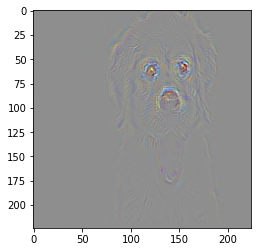

In [65]:
img = get_image(cam_gb)
plt.imshow(img)

In [42]:
#.shape
# grayscale_cam_gb = utils.convert_to_grayscale(img)
# img = get_image(grayscale_cam_gb)
# print(img.shape)
# plt.imshow(img)